## Importing required libraries

In [1]:
import warnings
warnings.simplefilter('ignore')

def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [2]:
from tqdm import tqdm
import time
from collections import OrderedDict
import re
import string

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Example Song (Input - Document)

In [3]:
song= """We are no strangers to love
You know the rules and so do I
A full commitments what Im thinking of
You wouldnt get this from any other guy
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
And if you ask me how Im feeling
Dont tell me youre too blind to see
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you"""

## Preprocessing

#### Tokenization

In [4]:
# a function to remove all not-word characters in a word
def preprocess_string(s):
    # remove all non-word charecters except numbers and letters
    s = re.sub(r"[^\w\s]",'',s)
    # replace all runs of witespaces with no space
    s = re.sub(r"\s+",'',s)
    # replace digits with no space
    s = re.sub(r"\d",'',s)
    return s

print(f"Example Input Word:- 'Word2Vec'\nExample Output Word:- {preprocess_string('Word2Vec')}")

Example Input Word:- 'Word2Vec'
Example Output Word:- WordVec


In [5]:
# using the "word_tokenize" function from "nltk" library for tokenization
def preprocess(words):
    tokens = word_tokenize(words)
    tokens = [preprocess_string(w) for w in tokens]
    return [w.lower() for w in tokens if len(w) != 0 or not(w in string.punctuation)]

tokens=preprocess(song) # preserves the order
vocabulary = set(tokens)
print(f"Example 1st ten tokens:-\n{tokens[0:10]}")
print(f'Total no of tokens :-{len(tokens)}')
print(f'Total no of unique tokens :-{len(vocabulary)}')

Example 1st ten tokens:-
['we', 'are', 'no', 'strangers', 'to', 'love', 'you', 'know', 'the', 'rules']
Total no of tokens :-385
Total no of unique tokens :-80


#### Calcualting the frequency distribution of tokens

In [6]:
# using the "FreqDist" function from "nltk" library to calculate the token frequecy
fdist = nltk.FreqDist(tokens)
display(fdist)

# total counts
print(f"Total word count:- {sum(fdist.values())}")
print(f"Total unique word count:- {len(list(fdist.keys()))} ")

FreqDist({'na': 40, 'gon': 38, 'you': 37, 'never': 36, 'and': 16, 'tell': 9, 'make': 8, 'say': 8, 'a': 7, 'give': 6, ...})

Total word count:- 385
Total unique word count:- 80 


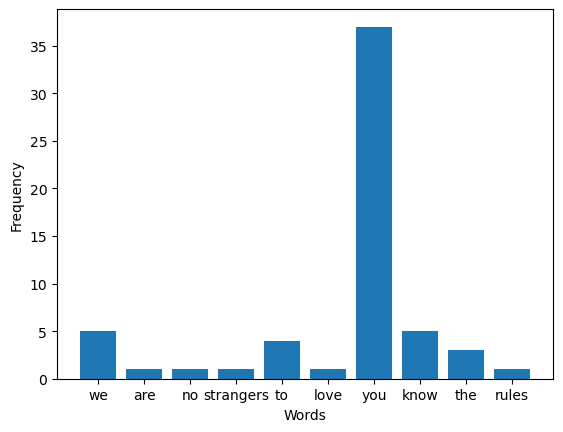

In [7]:
# a bar plot with the first ten token frequencies using the "pyplot" function from "matplotlib" library
plt.bar(list(fdist.keys())[0:10], list(fdist.values())[0:10])
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

## Bigram model

#### Creating bigrams

In [8]:
# creating consecutive pairs of tokens using the "bigrams" function from "nltk" library
bigrams = list(nltk.bigrams(tokens))
print(f'The first ten bigrmas:-\n{bigrams[:10]}')

The first ten bigrmas:-
[('we', 'are'), ('are', 'no'), ('no', 'strangers'), ('strangers', 'to'), ('to', 'love'), ('love', 'you'), ('you', 'know'), ('know', 'the'), ('the', 'rules'), ('rules', 'and')]


#### Calcutating the frequency distribution of bigrams

In [9]:
# using the "FreqDist" function from "nltk" library to calculate the bigram frequecy
freq_bigrams = nltk.FreqDist(nltk.bigrams(tokens))
display(freq_bigrams)

# total counts
print(f"Total bigram count:- {sum(freq_bigrams.values())}")
print(f"Total unique bigram count:- {len(list(freq_bigrams.keys()))} ")

FreqDist({('gon', 'na'): 38, ('never', 'gon'): 36, ('you', 'never'): 9, ('na', 'tell'): 8, ('make', 'you'): 8, ('na', 'give'): 6, ('give', 'you'): 6, ('you', 'up'): 6, ('up', 'never'): 6, ('na', 'let'): 6, ...})

Total bigram count:- 384
Total unique bigram count:- 119 


#### Calculating the conditional probabilities for the example token - "strangers"

In [10]:
word = 'strangers'
vocab_probabilities = {}
for next_word in vocabulary:
    vocab_probabilities[next_word] = freq_bigrams[(word, next_word)]/fdist[word]

vocab_probabilities = sorted(vocab_probabilities.items(), key=lambda x:x[1], reverse=True)

print("Top 4 more likely word to occur after 'strangers':-\n", vocab_probabilities[:4])

Top 4 more likely word to occur after 'strangers':-
 [('to', 1.0), ('shy', 0.0), ('and', 0.0), ('your', 0.0)]


#### A function for next word prediction using conditional probability of the next word given a sequence

In [11]:
def make_predictions(input_words, freq_grams, norm,vocabulary=vocabulary):
    vocab_probabilities = {}
    context_size = len(list(freq_grams.keys())[0]) # for bigram model, its = 2
    input_context_tokens = preprocess(input_words)[0:context_size-1] # taking only the relavent context tokens

    # calculating the probabilities
    for next_word in vocabulary:
        temp = input_context_tokens.copy()
        temp.append(next_word) # adding the next word to the context

        #calculating the conditional probability
        vocab_probabilities[next_word] = freq_grams[tuple(temp)] / norm

    # sorting the probabilities
    vocab_probabilities = sorted(vocab_probabilities.items(), key=lambda x:x[1], reverse=True)

    return vocab_probabilities

print("Top 4 more likely word to occur after 'strangers':-\n", make_predictions('strangers', freq_bigrams, fdist['strangers'])[:4])

Top 4 more likely word to occur after 'strangers':-
 [('to', 1.0), ('shy', 0.0), ('and', 0.0), ('your', 0.0)]


#### Generating a song using the bigram model

In [12]:
my_song="so"
input_word = my_song
for i in range(100):
    next_word = make_predictions(input_word, freq_bigrams, fdist[input_word])[0][0]
    my_song += " "+ next_word
    input_word = next_word

print(my_song)

so long your hearts been aching but youre too shy to say goodbye never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and
